In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e8/sample_submission.csv
/kaggle/input/playground-series-s3e8/train.csv
/kaggle/input/playground-series-s3e8/test.csv
/kaggle/input/gemstone-price-prediction/cubic_zirconia.csv
/kaggle/input/gemstone-price-prediction/Data Dictionary.xlsx


# Importing packages

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder ,LabelEncoder ,OrdinalEncoder
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e8/train.csv')
test_  = pd.read_csv('/kaggle/input/playground-series-s3e8/test.csv')
actual  = pd.read_csv('/kaggle/input/gemstone-price-prediction/cubic_zirconia.csv')

In [4]:
train = train.drop('id' ,axis =1)
actual = actual.dropna(axis = 0)
actual = actual.drop('Unnamed: 0' ,axis = 1)

In [5]:
og = pd.concat([train ,actual])

In [6]:
og.shape

(219843, 10)

In [7]:
og.head()

carat        cut color clarity  depth  table     x     y     z  price
0   1.52    Premium     F     VS2   62.2   58.0  7.27  7.33  4.55  13619
1   2.03  Very Good     J     SI2   62.0   58.0  8.06  8.12  5.05  13387
2   0.70      Ideal     G     VS1   61.2   57.0  5.69  5.73  3.50   2772
3   0.32      Ideal     G     VS1   61.6   56.0  4.38  4.41  2.71    666
4   1.70    Premium     G     VS2   62.6   59.0  7.65  7.61  4.77  14453

In [8]:
og.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219843 entries, 0 to 26966
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   carat    219843 non-null  float64
 1   cut      219843 non-null  object 
 2   color    219843 non-null  object 
 3   clarity  219843 non-null  object 
 4   depth    219843 non-null  float64
 5   table    219843 non-null  float64
 6   x        219843 non-null  float64
 7   y        219843 non-null  float64
 8   z        219843 non-null  float64
 9   price    219843 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 18.4+ MB


# 3.5 Correlation

## 3.5.1 Correlation matirx - For Numerical 
### If both the input and output variables are numeric, you can use either the Pearson or Spearman correlation matrix


<AxesSubplot:>

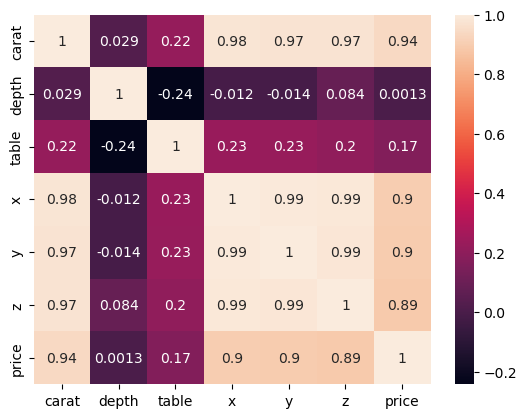

In [9]:
# 1 . pearson's correlation matrix
numeric = og[['carat' , 'depth' ,'table' ,'x' ,'y' ,'z' , 'price']] # this are the all numeric columns
sns.heatmap(numeric.corr() ,annot = True)

<AxesSubplot:>

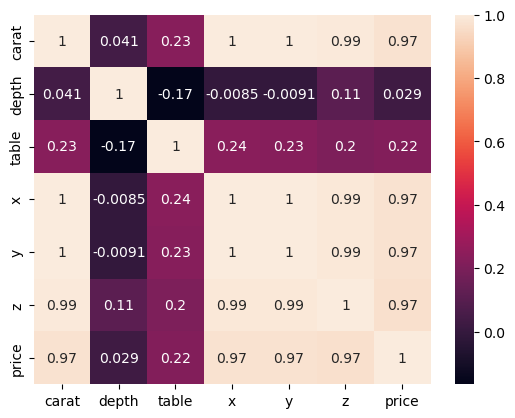

In [10]:
# 2. Spearman's 
sns.heatmap(numeric.corr("spearman") ,annot = True)

## 3.5.2 Correlation matirx - For Categorical
### If  input variables categorical and output variables are numeric, you can use Kendall's , ANNOVA

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


<AxesSubplot:>

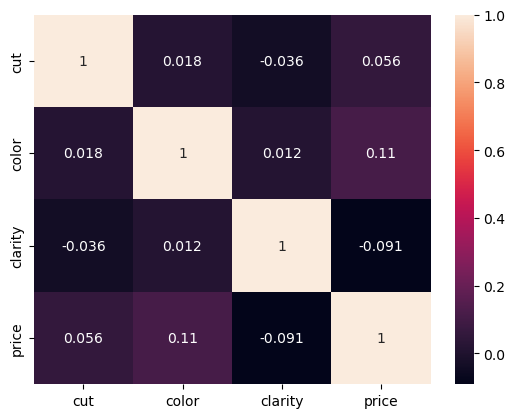

In [11]:
# 1. kendal's 
cate = og[['cut' ,'color' ,'clarity']]

encoder = LabelEncoder()

encoded = cate.apply(encoder.fit_transform)
encoded['price'] = train['price']

sns.heatmap(encoded.corr("kendall") ,annot = True)

In [12]:
# 2 ANNOVA test


# 3.6 plots

## Plots for numeric columns

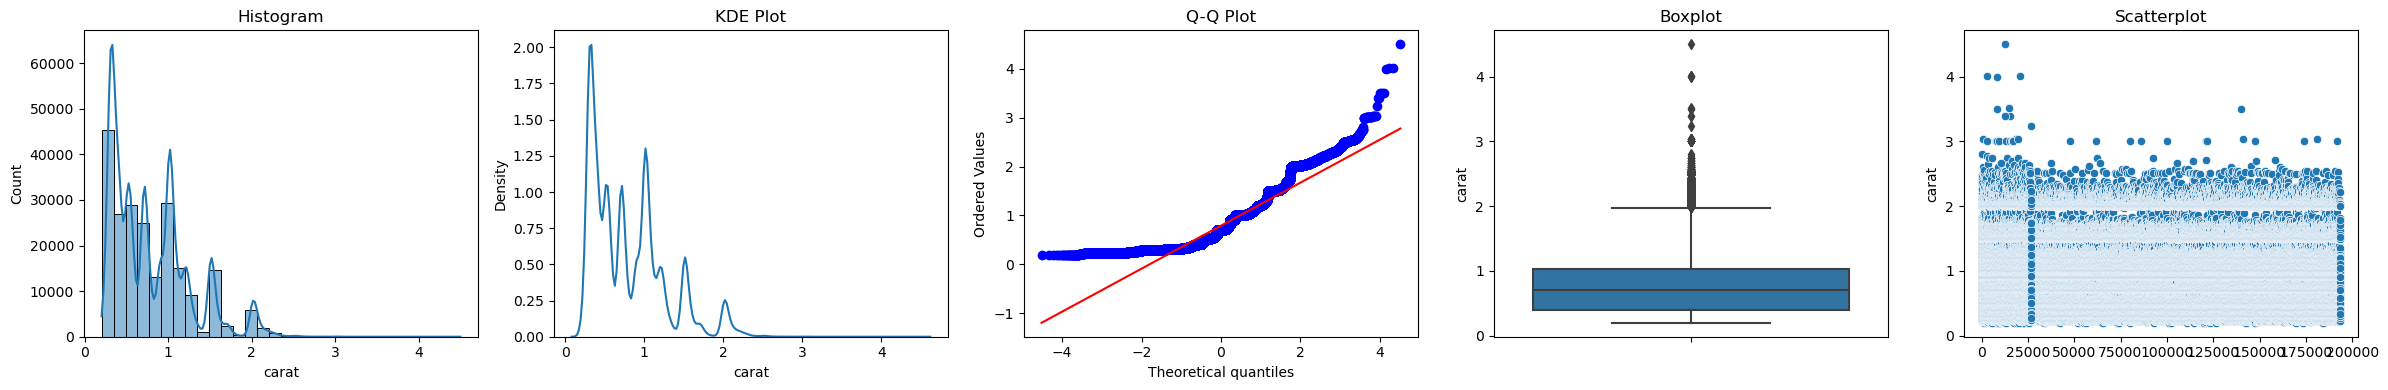

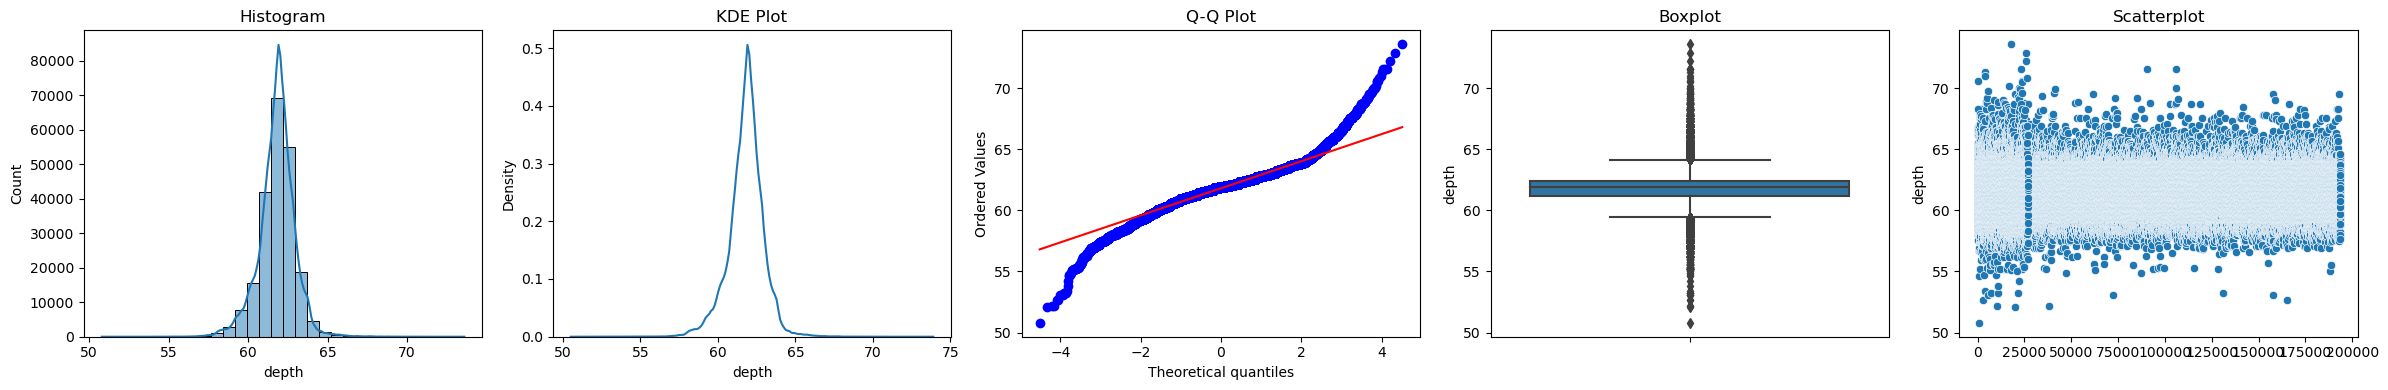

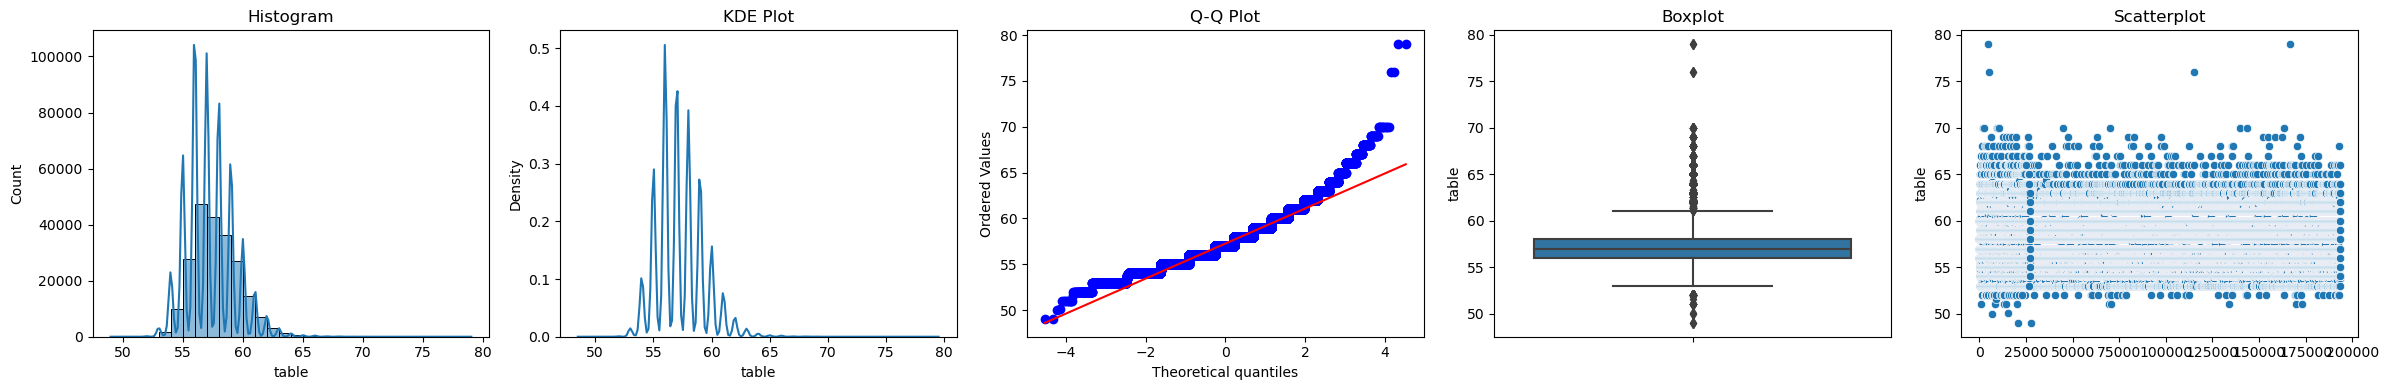

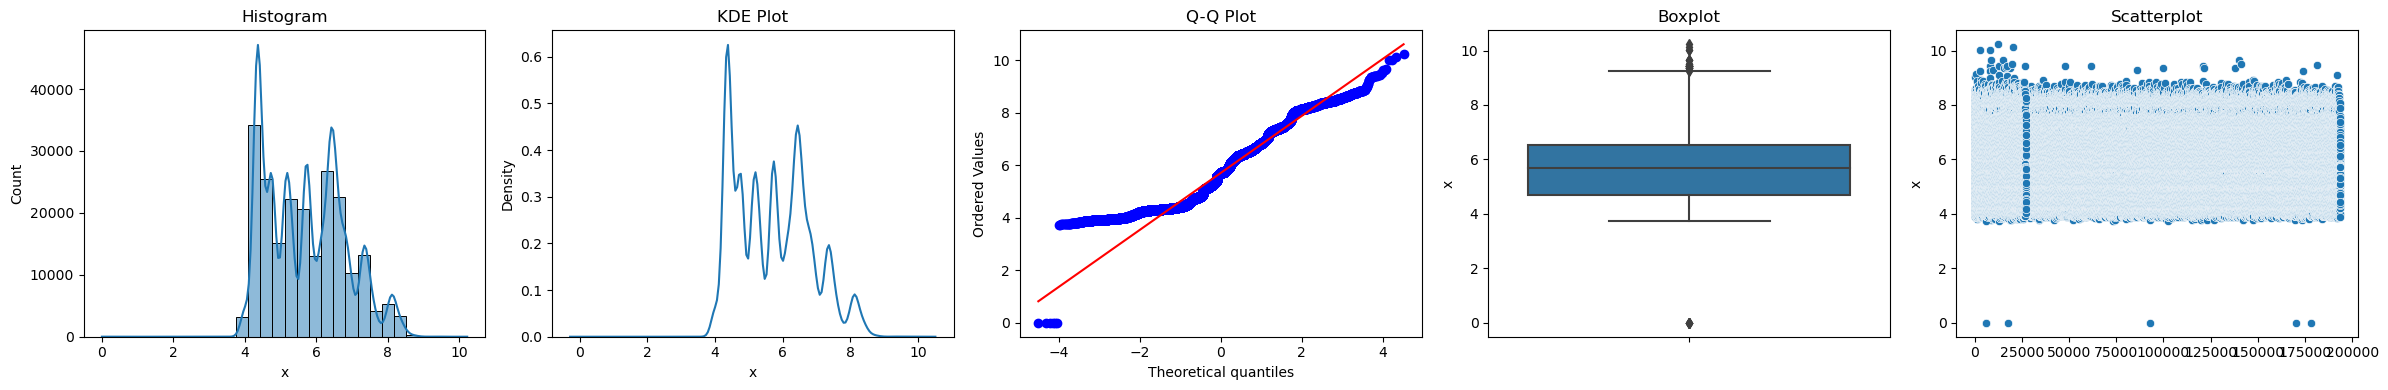

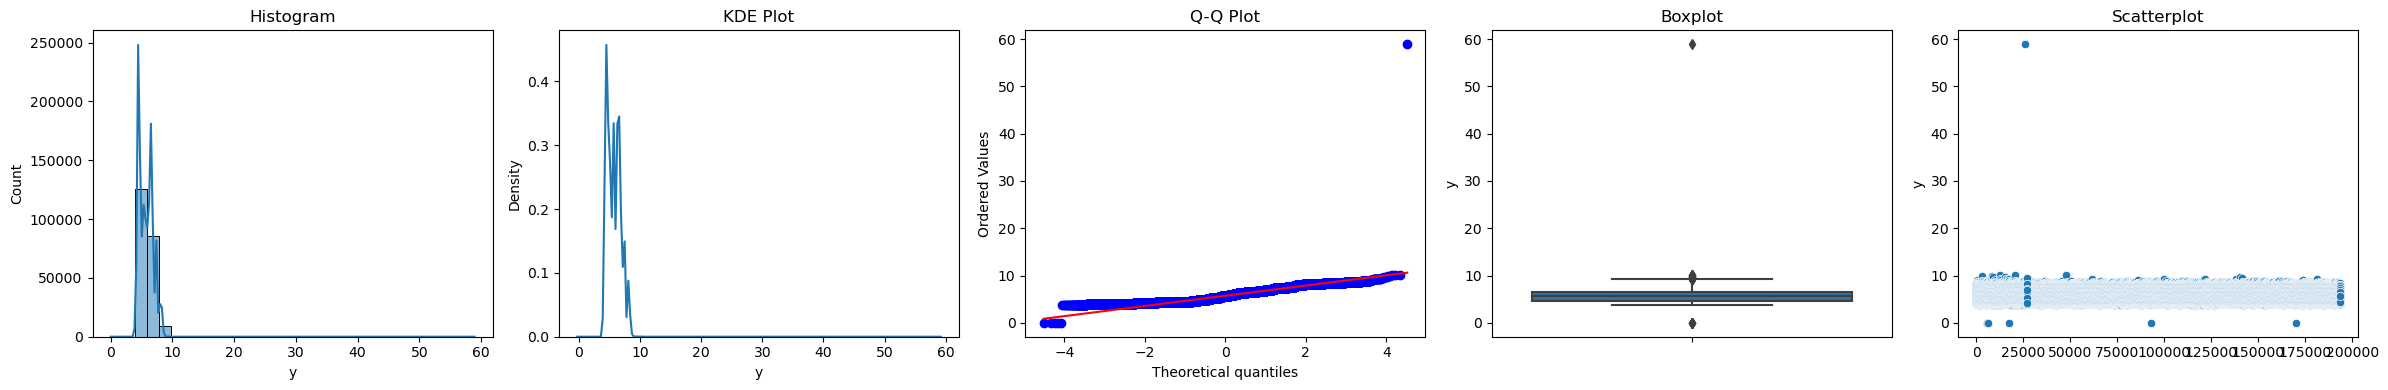

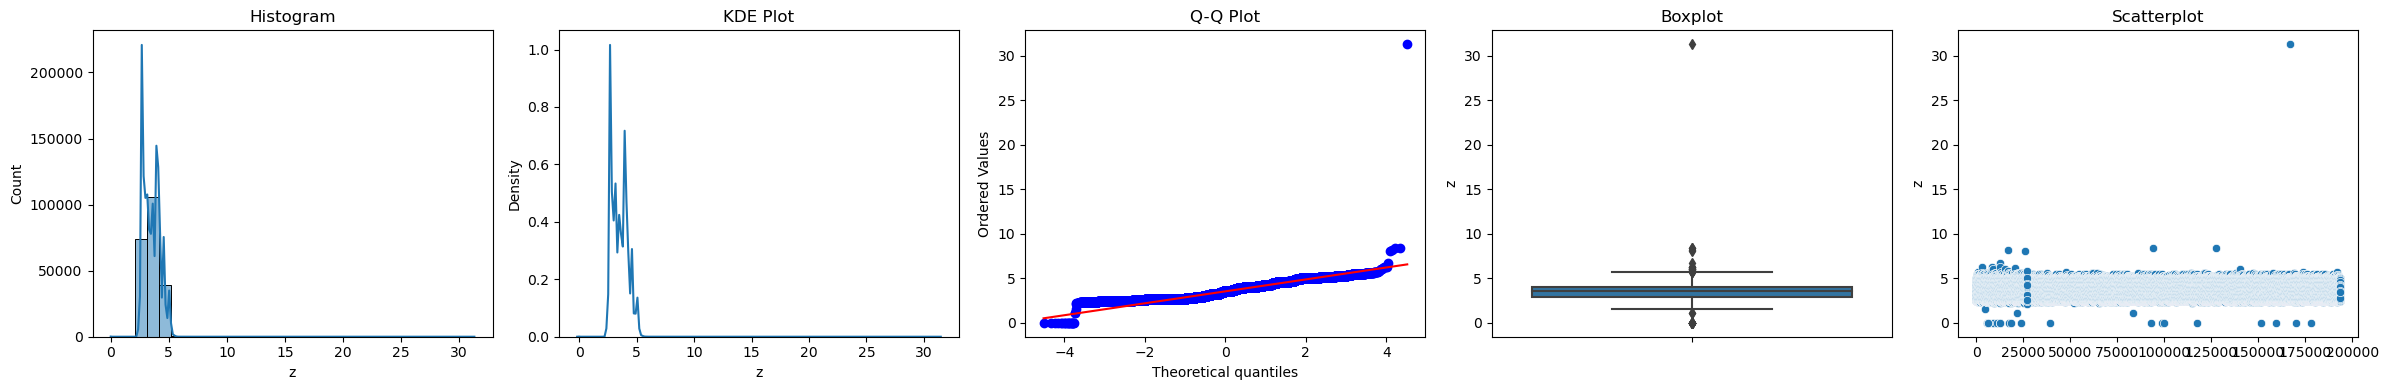

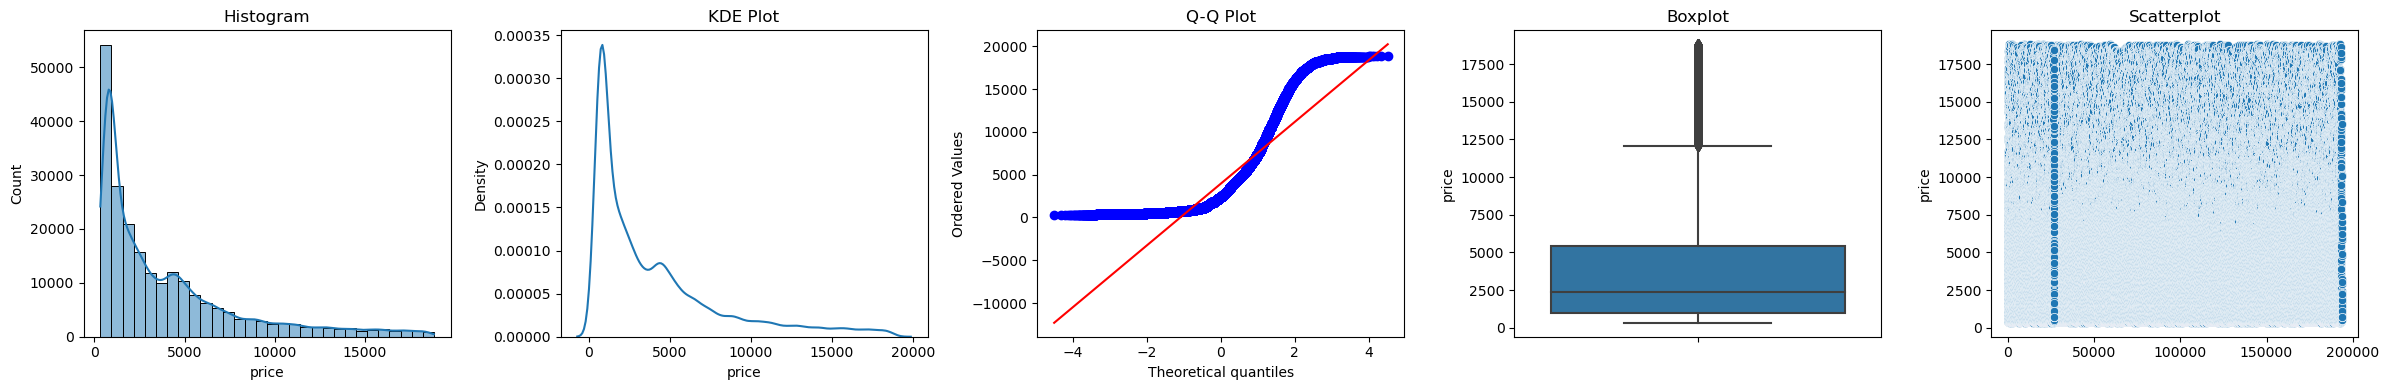

In [13]:
def plots(df, variable):
    # define figure size
    fig, ax = plt.subplots(1, 5, figsize=(24, 4))
    
    # histogram
    sns.histplot(df[variable], bins=30, kde=True, ax=ax[0])
    ax[0].set_title('Histogram')
    
    # KDE plot
    sns.kdeplot(df[variable], ax=ax[1])
    ax[1].set_title('KDE Plot')
    
    # Q-Q plots
    stats.probplot(df[variable], dist="norm", plot=ax[2])
    ax[2].set_title('Q-Q Plot')
    
    # boxplot
    sns.boxplot(y=df[variable], ax=ax[3])
    ax[3].set_title('Boxplot')
    
    # scatterplot
    sns.scatterplot(x=df.index, y=df[variable], ax=ax[4])
    ax[4].set_title('Scatterplot')
    
    plt.tight_layout()
    plt.show()

for i in numeric.columns:
    plots(numeric ,i)

## plots for categorical columns

In [14]:
cate.head()

cut color clarity
0    Premium     F     VS2
1  Very Good     J     SI2
2      Ideal     G     VS1
3      Ideal     G     VS1
4    Premium     G     VS2

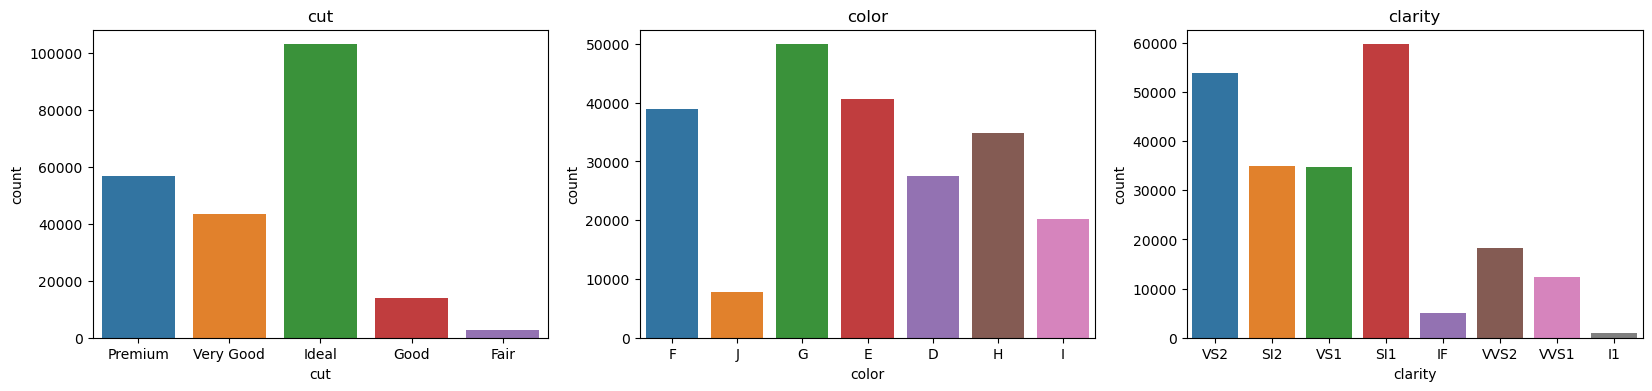

In [15]:
fig ,axs = plt.subplots(1,3 ,figsize = (20,4))
for i ,col in enumerate(cate.columns):
    sns.countplot(x=col, data=cate, ax =axs[i])
    axs[i].set_title(col)

# Outliers Info

In [16]:
def detect_outliers(data):
    outlier_percents = {}
    for column in data.columns:
        q1 = np.quantile(data[column], 0.25)
        q3 = np.quantile(data[column], 0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outlier_percent = (outliers.shape[0] / data.shape[0]) * 100
        outlier_percents[column] = outlier_percent
        
    outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage')


detect_outliers(numeric)

Outlier_percentage
y                0.013646
x                0.015011
z                0.018650
table            2.548182
carat            3.970106
depth            4.591913
price            6.532389

# Model training

In [17]:
color_dic = {'D':6,'E':5,'F':4,'G':3,'H':2,'I':1,'J':0}
clarity_dic = {'FL':10, 'IF':9, 'VVS1':8, 'VVS2':7, 'VS1':6, 'VS2':5, 'SI1':4, 'SI2':3, 'I1':2, 'I2':1, 'I3':0}

def process(df):
    df['color'] = df['color'].apply(lambda x:color_dic[x])
    df['clarity'] = df['clarity'].apply(lambda x:clarity_dic[x])
    return df

In [18]:
prediction_array = {'Premium': 0,
                   'Very Good':0,
                   'Ideal' : 0,
                   'Good' : 0 ,
                   'Fair' : 0}

skf = StratifiedKFold(shuffle=True ,random_state=42)


for num ,i in enumerate(og.cut.unique()):
    
    df = og.copy()
    test = test_.copy()
    
    print(num ,i)
    data_ = df[df['cut']  == i].drop('cut' ,axis = 1)
    test_str_ = test[test['cut']  == i].drop(['cut', 'id'] ,axis = 1)
    data = process(data_)
    test_str = process(test_str_)
    
    
    X = data.drop('price' ,axis = 1)
    y = data['price']
    
    
    y_preds = []

    for fold , (train_idx ,test_idx) in enumerate(skf.split(X,y)):
        X_train ,X_test = X.iloc[train_idx] , X.iloc[test_idx]
        y_train , y_test = y.iloc[train_idx] ,y.iloc[test_idx]

        model  = CatBoostRegressor(verbose=0)

        model.fit(X_train ,y_train)

        y_pred = model.predict(test_str)

        y_preds.append(y_pred)

    sample = pd.DataFrame(data = y_preds)
    sample = sample.T
    sample.columns = ["1","2","3","4" ,"5"]
    sample['add'] = sample.apply(lambda x : ((x['1']+x["2"]+x["3"]+x["4"]+x["5"])/5) ,axis = 1)
    x = np.array(sample['add'])
    prediction_array[i] = x

print("ok")

0 Premium


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


1 Very Good


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


2 Ideal


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


3 Good


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


4 Fair


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


ok


In [19]:
for i in test.cut.unique():
    inde = test[test['cut'] == i].index
    test.loc[inde , 'price'] = prediction_array[i]

In [20]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e8/sample_submission.csv')
sub['price'] =  test['price']
sub.to_csv('Submission.csv' , index = False)